# Clustering Epi Communities

In this notebook we'll attempt to cluster classify the different epi communities

#### Go to [model](#model)
#### Go to [feature selection](#feature) | [feature selection 2](#feature2)

# 1. Load data and Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

In [2]:
def save(df, name, ids, output_dir='outputs/'):
    '''
    - df = TARGETS
    - name = name of file
    - ids = dataframe containing ids
    - output_dir = default: outputs/
    '''
    location = os.path.join(output_dir, name)
    df_to_save = pd.DataFrame({'EPI_ID': ids, 'CLASS': df})
    df_to_save.to_csv(location, index=False)
    print(f'Saved @ {location}')

In [3]:
# Import the data

raw_df = pd.read_csv('datasets/epi_communities - epi_communities.csv')
raw_df[:3]

,EPI_ID,EPI_T_EN,IMM_S,TS_C,TS_N_EN,CT_C,CT_N_MM,VW_C,VW_T,VI_C,HF_L1_C,HF_L1_T,EPI_S_P,EP_S_U1,EP_S_U5,EP_S_U15,EP_S_PW,EP_S_WCBA
0,EPI00001559,Workers settlement,F,MMR013005,Taikkyi,NaN,NaN,MMR013005067,Village Track,150060,HF008182,Sub Rural Health Center,37.0,0.0,7.0,14.0,2.0,10.0
1,EPI00001870,Village,F,MMR013006,Htantabin,NaN,NaN,MMR013006048,Village Track,150167,HF008162,Rural Health Center,947.0,22.0,36.0,189.0,25.0,255.0
2,EPI00001871,Other settlement,F,MMR013006,Htantabin,NaN,NaN,MMR013006048,Village Track,150167,HF008162,Rural Health Center,89.0,0.0,5.0,25.0,1.0,26.0


In [4]:
len(raw_df)

553

In [5]:
raw_df.isnull().sum()

EPI_ID         0
EPI_T_EN       0
IMM_S          1
TS_C           0
TS_N_EN        0
CT_C         435
CT_N_MM      435
VW_C           0
VW_T           0
VI_C         119
HF_L1_C        0
HF_L1_T        0
EPI_S_P        1
EP_S_U1        1
EP_S_U5        1
EP_S_U15       1
EP_S_PW        1
EP_S_WCBA      1
dtype: int64

In [6]:
raw_df['CT_C'].value_counts()

MMR013008701    56
MMR013038701    29
MMR013039701    18
MMR013033701     9
MMR013006701     6
Name: CT_C, dtype: int64

In [7]:
raw_df["EPI_T_EN"].value_counts()

Village               271
Other settlement      138
Ward                   73
Workers settlement     59
Ward (p)               11
Army                    1
Name: EPI_T_EN, dtype: int64

## 1.1 Data Cleaning

A lot of null values for `CT_C` and `CT_N_MM`, let's remove them.
Lengthy classes with numerous null or unknown data `VI_C`, lengthy `VW_C`, `HF_L1_C`
For now let's keep the IDS to be used later `EPI_ID`

**Important points**
- `HF_L1_T` has a lot of null vales in the following form: `?????????????`

In [8]:
col_df = raw_df.drop(['CT_C', 'CT_N_MM', 'VW_C', 'VI_C', 'HF_L1_C'], axis=1)
col_df.isnull().sum()

EPI_ID       0
EPI_T_EN     0
IMM_S        1
TS_C         0
TS_N_EN      0
VW_T         0
HF_L1_T      0
EPI_S_P      1
EP_S_U1      1
EP_S_U5      1
EP_S_U15     1
EP_S_PW      1
EP_S_WCBA    1
dtype: int64

### a. Replace null values

IMM_S has NaN value on row 55, and row 211 is missing all EP_S.. values

In [9]:
df = col_df.drop([55, 211], axis=0)

In [10]:
nul = pd.isnull(df['EPI_S_P'])
df.isnull().sum()

EPI_ID       0
EPI_T_EN     0
IMM_S        0
TS_C         0
TS_N_EN      0
VW_T         0
HF_L1_T      0
EPI_S_P      0
EP_S_U1      0
EP_S_U5      0
EP_S_U15     0
EP_S_PW      0
EP_S_WCBA    0
dtype: int64

**Replace `HF_L1_T` '???????' with an appropriate value or delete**
Because it represents only 9 rows on 552, we could delete it. In this case we decide to represent it with a categorical value instead.

In [11]:
df['HF_L1_T'].value_counts()

Sub Rural Health Center             374
Rural Health Center                  71
Urban Health Center                  43
Sub Urban Health Center              36
Station Health Unit                  12
????????????????????                  9
Maternal and Child Health Center      6
Name: HF_L1_T, dtype: int64

### b. Transform data to binary or multi class

In [12]:
# Lets keep the raw DF for summary purposes
raw_df_truncated = df.copy()

In [13]:
# replacing values
df['EPI_T_EN'].replace(['Village', 'Other settlement', 'Ward', 'Workers settlement', 'Ward (p)', 'Army'],
                        [0, 1, 2, 3, 4, 5], inplace=True)
df['IMM_S'].replace(['O', 'F'], [0, 1], inplace=True)
df['TS_C'].replace(['MMR013006', 'MMR013008', 'MMR013038', 'MMR013039', 'MMR013033', 'MMR013005', 'MMR017021'],
                  [0, 1, 2, 3, 4, 5, 6], inplace = True)
df['TS_N_EN'].replace(['Htantabin', 'Hlaingtharya', 'Kyeemyindaing', 'Sanchaung', 'Kyauktada', 'Taikkyi', '?Nyaungdon'], 
                     [0, 1, 2, 3, 4, 5, 6], inplace=True)
df['VW_T'].replace(['Village Track', 'Ward'], [0, 1], inplace=True)
df['HF_L1_T'].replace(['Sub Rural Health Center', 'Rural Health Center', 'Urban Health Center', 'Sub Urban Health Center', 'Station Health Unit', '????????????????????', 'Maternal and Child Health Center']
                     , [0, 1, 2, 3, 4, 5, 6], inplace= True)

epi_id_idf = df['EPI_ID']
df.drop(['EPI_ID'], axis=1, inplace=True)
df

,EPI_T_EN,IMM_S,TS_C,TS_N_EN,VW_T,HF_L1_T,EPI_S_P,EP_S_U1,EP_S_U5,EP_S_U15,EP_S_PW,EP_S_WCBA
0,3,1,5,5,0,0,37.0,0.0,7.0,14.0,2.0,10.0
1,0,1,0,0,0,1,947.0,22.0,36.0,189.0,25.0,255.0
2,1,1,0,0,0,1,89.0,0.0,5.0,25.0,1.0,26.0
3,0,0,0,0,0,1,386.0,3.0,7.0,39.0,3.0,70.0
4,0,0,0,0,0,0,186.0,3.0,9.0,43.0,3.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...
548,1,0,0,0,0,1,32.0,0.0,1.0,4.0,0.0,10.0
549,1,1,0,0,0,1,68.0,1.0,1.0,16.0,0.0,18.0
550,1,0,0,0,0,1,286.0,5.0,26.0,30.0,2.0,78.0
551,0,0,1,1,0,1,1869.0,49.0,184.0,299.0,40.0,575.0


Dataset without IDs for Clustering 
- `df`

Below: Indexes of each ID for future use 
- `epi_id_idf`

<a id="model"></a>

# 2. Model

## 2.1 K-Means clustering

**a. Finding the right K cluster using Elbow Method**

In [14]:
# Initialize a k-means model given a dataset

def init_kmeans(X, k):
    m = X.shape[0]
    n = X.shape[1]
    means = np.zeros((k,n))
    order = np.random.permutation(m)[:k]
    for i in range(k):
        means[i,:] = X[order[i],:]
    return means

# Run one iteration of k-means

def iterate_kmeans(X, means):
    m = X.shape[0]
    n = X.shape[1]
    k = means.shape[0]
    distortion = np.zeros(m)
    c = np.zeros(m)
    for i in range(m):
        min_j = 0
        min_dist = 0
        for j in range(k):
            dist_j = np.linalg.norm(X[i,:] - means[j,:])
            if dist_j < min_dist or j == 0:
                min_dist = dist_j
                min_j = j
        distortion[i] = min_dist
        c[i] = min_j
    for j in range(k):
        means[j,:] = np.zeros((1,n))
        nj = 0
        for i in range(m):
            if c[i] == j:
                nj = nj + 1
                means[j,:] = means[j,:] + X[i,:]
        if nj > 0:
            means[j,:] = means[j,:] / nj
    return means, c, np.sum(distortion)

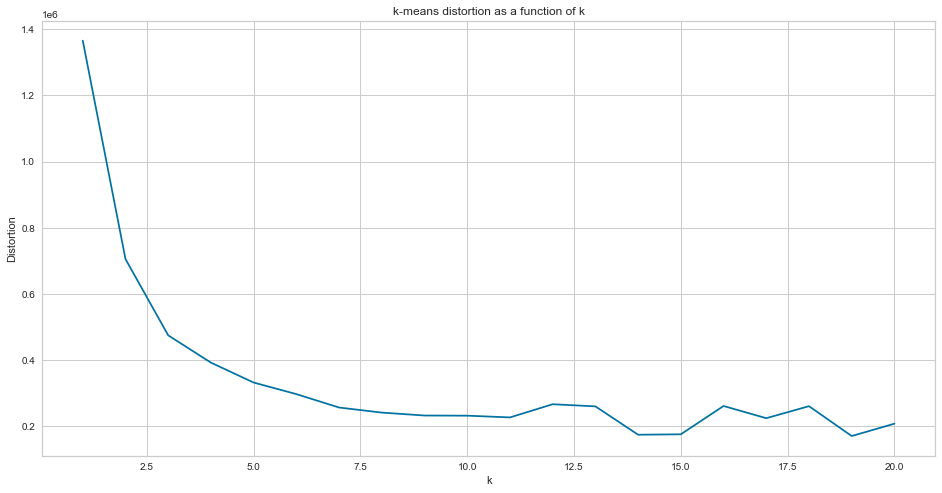

In [15]:
# Convert dataframe to matrix

X = np.array(df.iloc[:,1:])

# Intialize hyperparameters

max_k = 20
epsilon = 0.001

# For each value of k, do one run and record the resulting cost (Euclidean distortion)

distortions = np.zeros(max_k)
for k in range(1, max_k + 1):
    means = init_kmeans(X, k)
    prev_distortion = 0
    while True:
        means, c, distortion = iterate_kmeans(X, means)
        if prev_distortion > 0 and prev_distortion - distortion < epsilon:
            break
        prev_distortion = distortion
    distortions[k-1] = distortion

# Plot distortion as function of k

plt.figure(figsize=(16,8))
plt.plot(range(1,max_k+1), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('k-means distortion as a function of k')
plt.show()

**b. Silhouette Method**

In [16]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

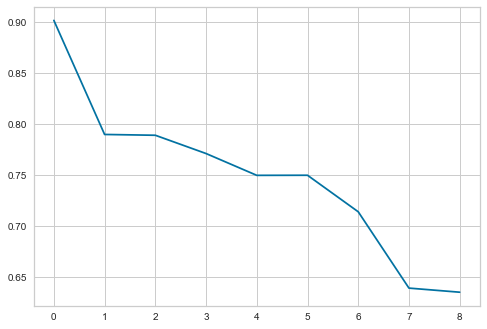

In [17]:
plt.plot(sil)
plt.show()

The analysis suggest that 6 is the right number of clusters

In [18]:
n_clusters = 5

In [19]:
km = KMeans(
    n_clusters=n_clusters, init='random',
    n_init=10, max_iter=1000, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

In [20]:
print(y_km)

[3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 2 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 4 3 3 3 3 3 3 3 3 2 3 2 2 3 3 2 3 3 3 3 2 3 3 2 3 3 3 3 3 3 3 3 2 3 3
 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 4 4 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 4 4 3
 2 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 3 3 3 2 4 4 4 4 4 4 2 2 2 4 4 4 4 4 4 2 4 4 4 4 3 4
 2 2 2 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 3 1 3 3 4 1 1 1 1 1 3 3 3 1 3 3
 1 3 3 3 0 0 3 3 3 3 2 3 3 3 3 4 4 0 3 3 3 3 4 2 4 3 4 3 3 3 4 3 3 3 0 3 3
 3 3 3 3 1 4 1 4 3 1 2 3 

**Concat ID and class**

In [21]:
classification_df = pd.DataFrame({'EPI_ID': epi_id_idf, 'CLASS': y_km})
classification_df

,EPI_ID,CLASS
0,EPI00001559,3
1,EPI00001870,3
2,EPI00001871,3
3,EPI00001868,3
4,EPI00001726,3
...,...,...
548,EPI00001725,3
549,EPI00001865,3
550,EPI00001866,3
551,EPI00003141,3


**Export to CSV**

In [22]:
!mkdir outputs
classification_df.to_csv('outputs/classification_results_kmeans.csv', index=False)
print("Done")

Done


A subdirectory or file outputs already exists.


<a id="feature"></a>

# 3 Feature Selection

## 3.1 Correlation

Text(0.5, 1.0, ' Correlation Heatmap')

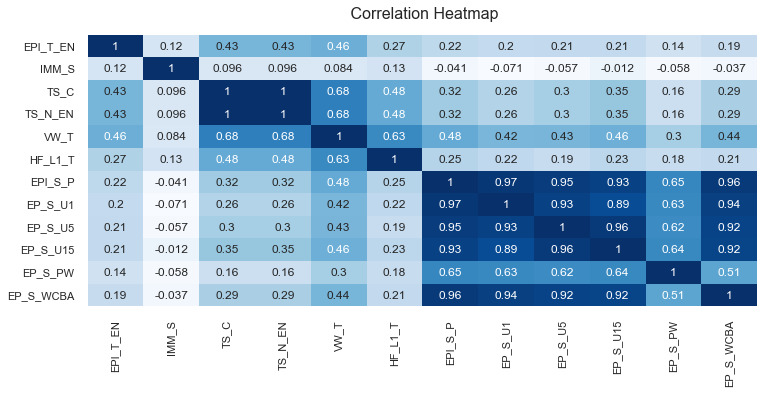

In [23]:
sns.set(rc={"figure.figsize":(12, 5)})
sns.heatmap(df.corr(),annot = True, cbar = False, cmap = "Blues").set_title(" Correlation Heatmap" , 
                                                                            fontdict={'fontsize':16}, pad=16)

We can see the last 6 variables are highly correlated. Indeed they all contain information about population number. Adding complexity to our model doesn't help with predictions but actually make it harder
Let's keep only 1 feature about population`EP_S_U5` = population under 5 and `EP_S_PW` = Pregnant women population

In [24]:
corr_df = df.drop(['EPI_S_P', 'EP_S_U1', 'EP_S_U15', 'EP_S_WCBA'], axis=1)

Text(0.5, 1.0, ' Correlation Heatmap')

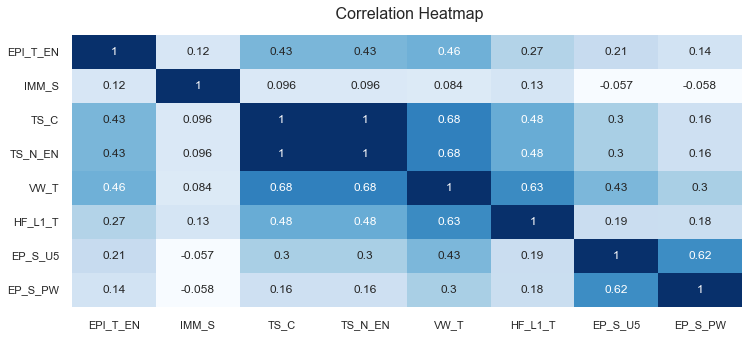

In [25]:
sns.set(rc={"figure.figsize":(12, 5)})
sns.heatmap(corr_df.corr(),annot = True, cbar = False, cmap = "Blues").set_title(" Correlation Heatmap" , 
                                                                            fontdict={'fontsize':16}, pad=16)

Let's note that `EPI_T_EN`, `TS_C`, `TS_N_EN`, `VW_T` are basically just information of code of the community as well as type. In another part we might be interested to remove those to see if it affects our predictions

In [26]:
corr_df.head()

,EPI_T_EN,IMM_S,TS_C,TS_N_EN,VW_T,HF_L1_T,EP_S_U5,EP_S_PW
0,3,1,5,5,0,0,7.0,2.0
1,0,1,0,0,0,1,36.0,25.0
2,1,1,0,0,0,1,5.0,1.0
3,0,0,0,0,0,1,7.0,3.0
4,0,0,0,0,0,0,9.0,3.0


## 3.2 Distribution

What we want to do now is see if our data is evenly distributed. Based on the results, we might want to do some normalization

<AxesSubplot:xlabel='EP_S_PW', ylabel='Count'>

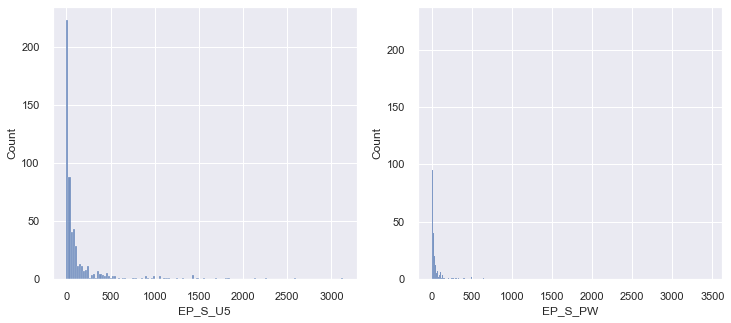

In [27]:
fig, (axe1, axe2) = plt.subplots(1,2)
sns.histplot(corr_df["EP_S_U5"], ax=axe1)
sns.histplot(corr_df["EP_S_PW"], ax=axe2)

In [28]:


temp_df = corr_df[["EP_S_U5", "EP_S_PW"]]
scaler = StandardScaler()
scaler.fit(temp_df)
temp_df = scaler.transform(temp_df)
corr_df["EP_S_U5"] = temp_df.transpose()[0]
corr_df["EP_S_PW"] = temp_df.transpose()[1]
corr_df

,EPI_T_EN,IMM_S,TS_C,TS_N_EN,VW_T,HF_L1_T,EP_S_U5,EP_S_PW
0,3,1,5,5,0,0,-0.416784,-0.244034
1,0,1,0,0,0,1,-0.330211,-0.111751
2,1,1,0,0,0,1,-0.422755,-0.249786
3,0,0,0,0,0,1,-0.416784,-0.238283
4,0,0,0,0,0,0,-0.410814,-0.238283
...,...,...,...,...,...,...,...,...
548,1,0,0,0,0,1,-0.434696,-0.255537
549,1,1,0,0,0,1,-0.434696,-0.255537
550,1,0,0,0,0,1,-0.360064,-0.244034
551,0,0,1,1,0,1,0.111609,-0.025480


<AxesSubplot:xlabel='EP_S_PW', ylabel='Count'>

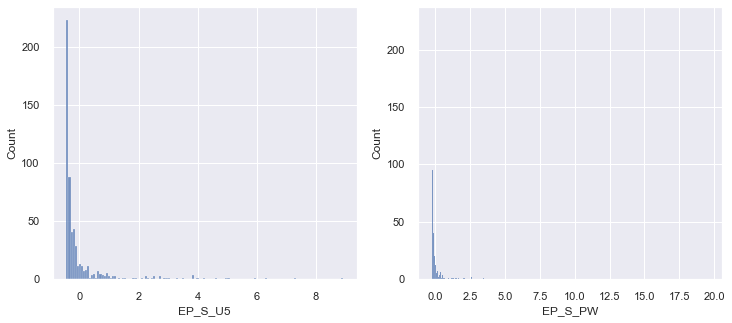

In [29]:
fig, (axe1, axe2) = plt.subplots(1,2)
sns.histplot(corr_df["EP_S_U5"], ax=axe1)
sns.histplot(corr_df["EP_S_PW"], ax=axe2)

Categorical features

In [30]:

# fig, (ax1, ax2, ax3) = plt.subplots(1,3)
# sns.histplot(corr_df["EPI_T_EN"], ax=ax1)
# sns.histplot(corr_df["IMM_S"], ax=ax2)
# sns.histplot(corr_df["TS_C"], ax=ax3)

# fig2, (ax4, ax5, ax6) = plt.subplots(1,3)
# sns.histplot(corr_df["TS_N_EN"], ax=ax4)
# sns.histplot(corr_df["VW_T"], ax=ax5)
# sns.histplot(corr_df["HF_L1_T"], ax=ax6)

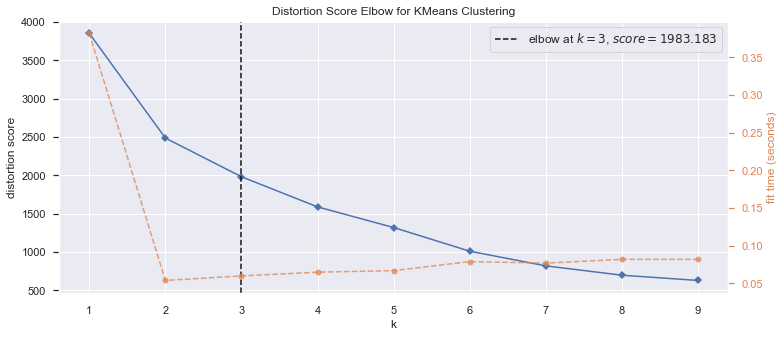

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,10))
visualize.fit(corr_df)
visualize.poof()

It seems K=3 is the best cluster number

In [32]:
X = np.array(corr_df.iloc[:, 1:])

In [33]:
model = KMeans(n_clusters=3, random_state=42)
y_preds = model.fit_predict(X)

In [34]:
print(y_preds)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 2 1 1 1 1 1 1
 2 0 0 0 2 2 0 0 0 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 0 2 0 0
 0 0 0 1 2 1 2 1 1 2 1 1 

In [35]:
classification_df = corr_df
classification_df["clusters"] = model.labels_
classification_df.head()

,EPI_T_EN,IMM_S,TS_C,TS_N_EN,VW_T,HF_L1_T,EP_S_U5,EP_S_PW,clusters
0,3,1,5,5,0,0,-0.416784,-0.244034,1
1,0,1,0,0,0,1,-0.330211,-0.111751,0
2,1,1,0,0,0,1,-0.422755,-0.249786,0
3,0,0,0,0,0,1,-0.416784,-0.238283,0
4,0,0,0,0,0,0,-0.410814,-0.238283,0


In [36]:
save(y_preds, 'classification_with_regions_5_features_kmeans_k3.csv', epi_id_idf)

Saved @ outputs/classification_with_regions_5_features_kmeans_k3.csv


<hr>

<a id="feature2"></a>
# 4. Feature Selection 2

Here let's remove the township/region info from our database and see what happens

In [37]:
df_truncated = corr_df.drop(["EPI_T_EN", "TS_C", "TS_C", "TS_N_EN", "VW_T", "HF_L1_T"], axis=1)
df_truncated.head()

,IMM_S,EP_S_U5,EP_S_PW,clusters
0,1,-0.416784,-0.244034,1
1,1,-0.330211,-0.111751,0
2,1,-0.422755,-0.249786,0
3,0,-0.416784,-0.238283,0
4,0,-0.410814,-0.238283,0


## Finding the right K cluster number

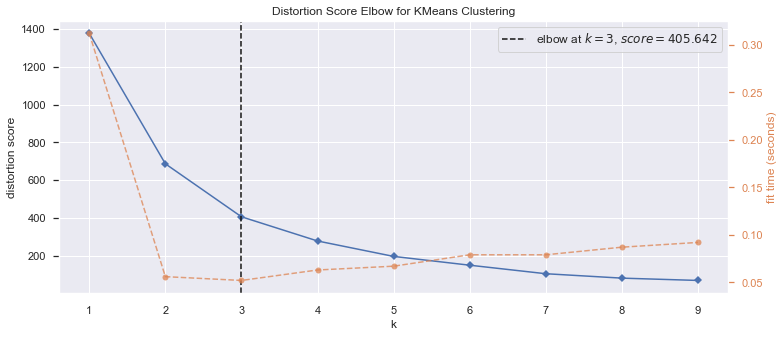

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
model2 = KMeans()
visualize = KElbowVisualizer(model2, k=(1,10))
visualize.fit(df_truncated)
visualize.poof()

### KMEANS USING 3 CLUSTERS

In [39]:
n_clusters = 3

km = KMeans(
    n_clusters=n_clusters, init='random',
    n_init=10, max_iter=1000, 
    tol=1e-04, random_state=42
)
y_km2 = km.fit_predict(df_truncated)
classification_df2 = raw_df_truncated[['IMM_S', 'EP_S_U5', 'EP_S_PW']].copy()
classification_df2["clusters"] = km.labels_
classification_df2.head()

,IMM_S,EP_S_U5,EP_S_PW,clusters
0,F,7.0,2.0,1
1,F,36.0,25.0,1
2,F,5.0,1.0,1
3,O,7.0,3.0,0
4,O,9.0,3.0,0


In [40]:
save(y_km2, 'classification_3_features_kmeans_k3.csv', epi_id_idf)

Saved @ outputs/classification_3_features_kmeans_k3.csv


# 4 Summary of results

In [41]:
cluster1 = classification_df2.drop("IMM_S", axis=1)[classification_df2.clusters == 0]
cluster2 = classification_df2.drop("IMM_S", axis=1)[classification_df2.clusters == 1]
cluster3 = classification_df2.drop("IMM_S", axis=1)[classification_df2.clusters == 2]

In [42]:
preds2_mean = pd.DataFrame(classification_df2.drop("IMM_S", axis=1).mean())
preds2_mean["cluster 1"] = cluster1.mean()
preds2_mean["cluster 2"] = cluster2.mean()
preds2_mean["cluster 3"] = cluster3.mean()
preds2_mean.rename(columns={0: 'all data'}, inplace=True)
preds2_mean

,all data,cluster 1,cluster 2,cluster 3
EP_S_U5,146.613430,84.215385,101.034146,1557.238095
EP_S_PW,44.430127,19.664615,25.121951,616.190476
clusters,0.448276,0.000000,1.000000,2.000000


# 5. Changing variables

Previous experiments were not satisfying, the reason being is that the number of pregnant women and under 5 population is proportional to the population number (urban areas). As a result we will change these features to percentages instead

In [177]:
df.head()

,EPI_T_EN,IMM_S,TS_C,TS_N_EN,VW_T,HF_L1_T,EPI_S_P,EP_S_U1,EP_S_U5,EP_S_U15,EP_S_PW,EP_S_WCBA
0,3,1,5,5,0,0,37.0,0.0,7.0,14.0,2.0,10.0
1,0,1,0,0,0,1,947.0,22.0,36.0,189.0,25.0,255.0
2,1,1,0,0,0,1,89.0,0.0,5.0,25.0,1.0,26.0
3,0,0,0,0,0,1,386.0,3.0,7.0,39.0,3.0,70.0
4,0,0,0,0,0,0,186.0,3.0,9.0,43.0,3.0,66.0


In [279]:
df_percent = df.copy()
df_percent['under_5'] = (df_percent['EP_S_U5'] / df_percent['EPI_S_P'])
df_percent['pregnant'] = (df_percent['EP_S_PW'] / df_percent['EPI_S_P']) 
df_percent = df_percent.drop(['EP_S_U1', 'EP_S_U15', 'EP_S_WCBA'], axis=1) # remove high correlation ones
df_percent = df_percent.drop(["TS_C", "TS_C", "TS_N_EN", "HF_L1_T"], axis=1) # remove info about location + immuno strategy one
df_percent.drop(['EPI_S_P'], axis=1, inplace=True) # removes total population
df_percent.drop(['EP_S_U5', 'EP_S_PW'], axis=1, inplace=True)


# df_percent = df_percent.drop(["TS_C", "TS_N_EN", "VW_T", "HF_L1_T"], axis=1) # for present

# df_percent.drop(['EPI_S_P'], axis=1, inplace=True)
df_percent

,EPI_T_EN,IMM_S,VW_T,under_5,pregnant
0,3,1,0,0.189189,0.054054
1,0,1,0,0.038015,0.026399
2,1,1,0,0.056180,0.011236
3,0,0,0,0.018135,0.007772
4,0,0,0,0.048387,0.016129
...,...,...,...,...,...
548,1,0,0,0.031250,0.000000
549,1,1,0,0.014706,0.000000
550,1,0,0,0.090909,0.006993
551,0,0,0,0.098448,0.021402


In [280]:
temp_df = df_percent[["under_5", "pregnant"]]
scaler = StandardScaler()
scaler.fit(temp_df)
temp_df = scaler.transform(temp_df)
df_percent["under_5"] = temp_df.transpose()[0]
df_percent["pregnant"] = temp_df.transpose()[1]
df_percent

,EPI_T_EN,IMM_S,VW_T,under_5,pregnant
0,3,1,0,1.245459,1.212752
1,0,1,0,-0.936901,0.089888
2,1,1,0,-0.674670,-0.525779
3,0,0,0,-1.223890,-0.666425
4,0,0,0,-0.787166,-0.327107
...,...,...,...,...,...
548,1,0,0,-1.034558,-0.981990
549,1,1,0,-1.273389,-0.981990
550,1,0,0,-0.173317,-0.698055
551,0,0,0,-0.064479,-0.113018


<AxesSubplot:xlabel='under_5', ylabel='Count'>

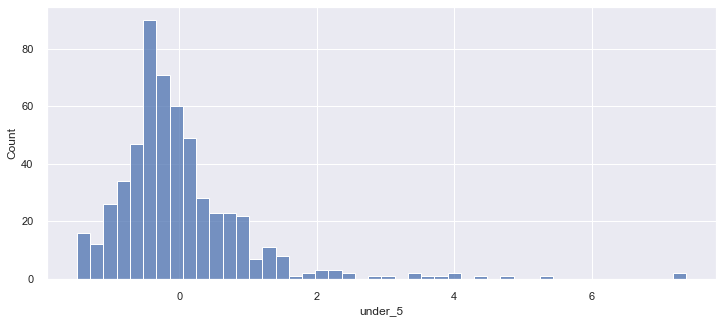

In [281]:
sns.histplot(df_percent["under_5"])

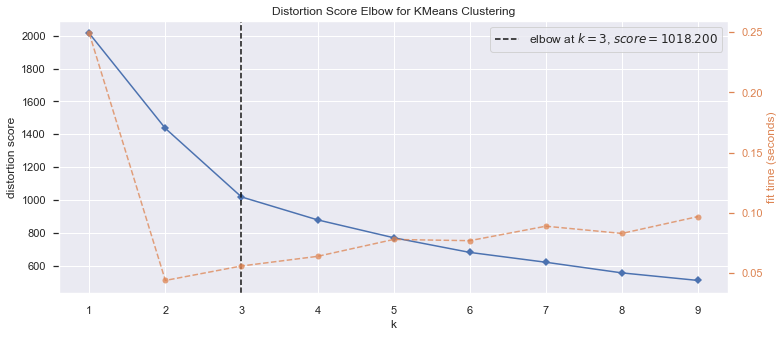

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [282]:
model3 = KMeans()
visualize = KElbowVisualizer(model3, k=(1,10))
visualize.fit(df_percent)
visualize.poof()

In [283]:
n_clusters = 3

km = KMeans(
    n_clusters=n_clusters, init='random',
    n_init=10, max_iter=1000, 
    tol=1e-04, random_state=42
)
y_km3 = km.fit_predict(df_percent)
print(y_km3)

[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 0 1 0 1 0 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 2 1 1 1 1 1 2 2 2 2 1 1 1 0 0 0 0
 1 1 1 2 0 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 2 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1
 0 2 0 1 0 0 1 1 1 2 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 2 0 0 1 1 0 1 1
 1 1 1 1 0 0 0 0 1 2 0 0 

In [284]:
save(y_km3, f'classification_5_features_kmeans_with_percentages_+totalpopulation+EPI_T_EN_k{n_clusters}.csv', epi_id_idf)

Saved @ outputs/classification_5_features_kmeans_with_percentages_+totalpopulation+EPI_T_EN_k3.csv


In [285]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # x = np.array(df_percent['EPI_T_EN'])
# y = np.array(df_percent['under_5'])
# z = np.array(df_percent['pregnant'])

# ax.scatter(x,y,z, marker="s", c=y_km3, s=40, cmap="viridis")

# plt.show()

In [286]:
df_percent["clusters"] = km.labels_
df_percent.head()

,EPI_T_EN,IMM_S,VW_T,under_5,pregnant,clusters
0,3,1,0,1.245459,1.212752,0
1,0,1,0,-0.936901,0.089888,1
2,1,1,0,-0.674670,-0.525779,1
3,0,0,0,-1.223890,-0.666425,1
4,0,0,0,-0.787166,-0.327107,1


In [287]:
drop = ['EPI_T_EN']
cluster1 = df_percent.drop(drop, axis=1)[df_percent.clusters == 0]
cluster2 = df_percent.drop(drop, axis=1)[df_percent.clusters == 1]
cluster3 = df_percent.drop(drop, axis=1)[df_percent.clusters == 2]
# cluster4 = df_percent.drop(drop, axis=1)[df_percent.clusters == 3]

# cluster1 = df_percent[df_percent.clusters == 0]
# cluster2 = df_percent[df_percent.clusters == 1]
# cluster3 = df_percent[df_percent.clusters == 2]

preds3_mean = pd.DataFrame(df_percent.drop(drop, axis=1).mean()) # drop
# preds3_mean = pd.DataFrame(df_percent.mean()) # not drop
preds3_mean["cluster 0"] = cluster1.mean()
preds3_mean["cluster 1"] = cluster2.mean()
preds3_mean["cluster 2"] = cluster3.mean()
# preds3_mean["cluster 3"] = cluster4.mean()
preds3_mean.rename(columns={0: 'all data'}, inplace=True)
preds3_mean

,all data,cluster 0,cluster 1,cluster 2
IMM_S,3.793103e-01,0.591241,0.312500,0.266667
VW_T,2.141561e-01,0.605839,0.078125,0.166667
under_5,-3.868654e-17,-0.215233,-0.116529,2.474468
pregnant,-1.934327e-17,-0.307916,-0.110842,2.824929
clusters,8.058076e-01,0.000000,1.000000,2.000000
